In [1]:
import os
import numpy as np
import sklearn.metrics
import torch
from torch.utils.data import Subset, DataLoader

import matplotlib.pyplot as plt
import sys
sys.path.append('..')

from utils.config_reader import ConfigReader
from models import get_model
from datasets.hitgraphs import HitGraphDataset, collate_fn

In [2]:
%matplotlib inline

In [3]:
def get_output_dir(config):
    return os.path.expandvars(config['train']['result_dir'])

def get_input_dir(config):
    return os.path.expandvars(config['train']['input_dir'])

def load_config(config_file):
    return ConfigReader(config_file).cfg

def load_summaries(config):
    summary_file = os.path.join(get_output_dir(config), 'summaries.npz')
    return np.load(summary_file)

def load_model(config, reload_epoch):
    print('loading model')
    model_config = config['model']
    model_type = model_config.pop('name')
    model_config.pop('optimizer', None)
    model_config.pop('learning_rate', None)
    model_config.pop('loss_func', None)
    model = get_model(name=model_type, **model_config)
    
    # Reload specified model checkpoint
    output_dir = get_output_dir(config)
    checkpoint_file = os.path.join(output_dir, 'checkpoints',
                                   'model_checkpoint_%03i.pth.tar' % reload_epoch)
    model.load_state_dict(torch.load(checkpoint_file, map_location='cpu')['model'])
    return model


In [4]:
config_file = '../configs/evaluate_config.yaml'

In [5]:
config = load_config(config_file)
summaries = load_summaries(config)

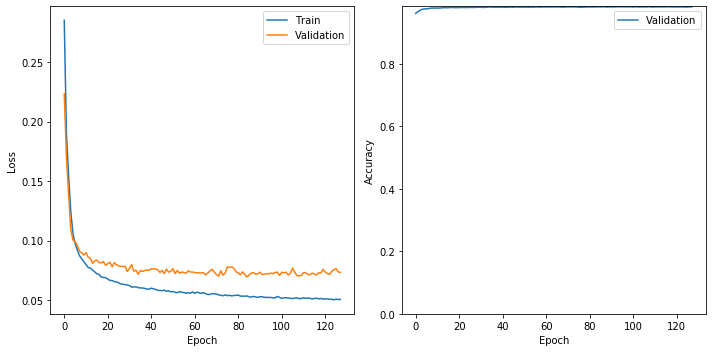

In [6]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(10, 5))

ax0.plot(summaries['epoch'], summaries['train_loss'], label='Train')
ax0.plot(summaries['epoch'], summaries['valid_loss'], label='Validation')
ax0.set_xlabel('Epoch', )
ax0.set_ylabel('Loss')
ax0.legend(loc=0)

ax1.plot(summaries['epoch'], summaries['valid_acc'], label='Validation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(bottom=0, )
ax1.legend(loc=0)

plt.tight_layout()

In [7]:
model = load_model(config, reload_epoch=127).eval()

loading model


In [13]:
n_test = 70

In [14]:
full_dataset = HitGraphDataset(get_input_dir(config))

# Take the test set from the back
test_indices = len(full_dataset) - 1 - torch.arange(n_test)
test_dataset = Subset(full_dataset, test_indices)
test_loader = DataLoader(test_dataset, collate_fn=collate_fn)

In [15]:
%%time

with torch.no_grad():
    test_outputs = [(model(batch_input).flatten(), batch_target.flatten())
                    for (batch_input, batch_target) in test_loader]
    test_pred, test_target = zip(*test_outputs)
    test_pred = np.concatenate(test_pred)
    test_target = np.concatenate(test_target)


Wall time: 1.85 s


In [37]:
thresh = 0.5
y_pred, y_true = (test_pred > thresh), (test_target > thresh)
print('Test set results with threshold of', thresh)
print('Accuracy:  %.4f' % sklearn.metrics.accuracy_score(y_true, y_pred))
print('Precision: %.4f' % sklearn.metrics.precision_score(y_true, y_pred))
print('Recall:    %.4f' % sklearn.metrics.recall_score(y_true, y_pred))

Test set results with threshold of 0.5
Accuracy:  0.9891
Precision: 0.7868
Recall:    0.7413


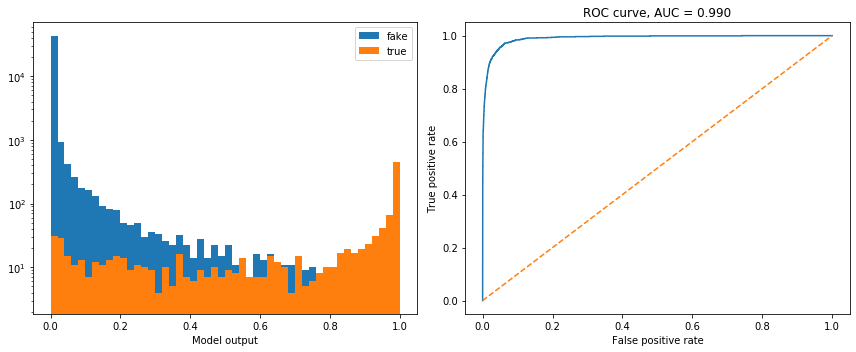

In [17]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, test_pred)

#%%

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12,5))

# Plot the model outputs
binning=dict(bins=50, range=(0,1), histtype='bar', log=True)
ax0.hist(test_pred[y_true==False], label='fake', **binning)
ax0.hist(test_pred[y_true], label='true', **binning)
ax0.set_xlabel('Model output')
ax0.legend(loc=0)

# Plot the ROC curve
auc = sklearn.metrics.auc(fpr, tpr)
ax1.plot(fpr, tpr)
ax1.plot([0, 1], [0, 1], '--')
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.set_title('ROC curve, AUC = %.3f' % auc)

plt.tight_layout()

In [18]:
from utils.old_visualizer import draw_single

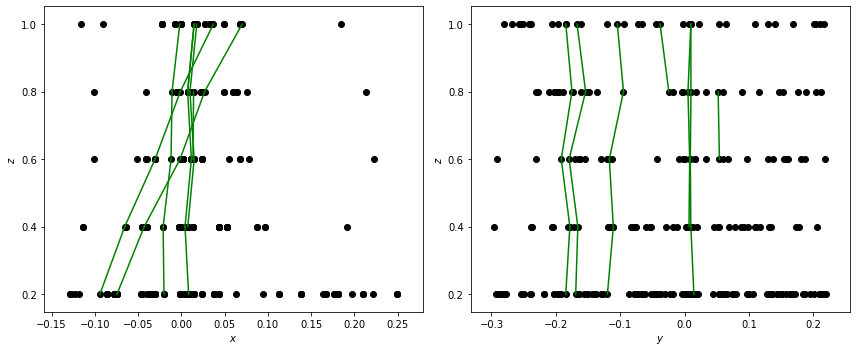

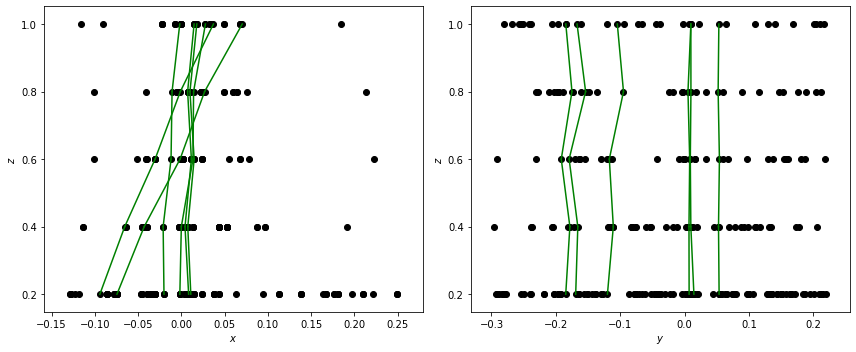

Wall time: 1.99 s


In [29]:
%%time

n_draw = 26

X, Ri, Ro, y = test_dataset[n_draw]
pred = test_outputs[n_draw][0].numpy()
draw_single(X, Ri, Ro, pred, c_fake=(0,0,0,0.0), xcord1=(0, 'x'), xcord2=(1, 'y'), ycord=(2, 'z'))
draw_single(X, Ri, Ro, y, c_fake=(0,0,0,0.0), xcord1=(0, 'x'), xcord2=(1, 'y'), ycord=(2, 'z'))